In [43]:

from pathlib import Path
import pandas as pd

BASE_DIR = Path.cwd()

file_path = BASE_DIR / ".." / ".." / "data" / "iad_dca_states_smoketest.parquet"

df = pd.read_parquet(file_path)

# Convert to datetime
df["snapshot_time"] = pd.to_datetime(df["snapshot_time"], utc=True)

# Sort first
df = df.sort_values(["icao24", "snapshot_time"])

# Remove duplicates while snapshot_time is still a column
df = df.drop_duplicates(subset=["icao24", "snapshot_time"])

# NOW set index
df = df.set_index("snapshot_time")


df = df.ffill()
df = df[df["velocity"] >= 0]
df = df[df["geo_altitude"] >= 0]



In [45]:
# 10-second digital twin dataset
df_resampled = (
    df.groupby("icao24")
      .resample("10s")
      .agg({
          "latitude": "mean",
          "longitude": "mean",
          "velocity": "mean",
          "geo_altitude": "mean",
          "vertical_rate": "mean",
          "true_track": "mean"
      })
      .reset_index()
)

# 1-minute ML dataset
df_minute = (
    df.groupby("icao24")
      .resample("1min")
      .agg({
          "velocity": "mean",
          "geo_altitude": "mean",
          "vertical_rate": "mean"
      })
      .reset_index()
)

print(df_resampled.head())
print(df_minute.head())


   icao24             snapshot_time  latitude  longitude  velocity  \
0  a01097 2026-02-16 21:27:10+00:00   39.0827   -77.4145    158.41   
1  a0b845 2026-02-16 21:27:10+00:00   38.8418   -77.0379      0.00   
2  a0b845 2026-02-16 21:27:20+00:00       NaN        NaN       NaN   
3  a0b845 2026-02-16 21:27:30+00:00       NaN        NaN       NaN   
4  a0b845 2026-02-16 21:27:40+00:00       NaN        NaN       NaN   

   geo_altitude  vertical_rate  true_track  
0       3970.02           6.83      337.27  
1       3970.02           6.83      101.25  
2           NaN            NaN         NaN  
3           NaN            NaN         NaN  
4           NaN            NaN         NaN  
   icao24             snapshot_time  velocity  geo_altitude  vertical_rate
0  a01097 2026-02-16 21:27:00+00:00    158.41       3970.02           6.83
1  a0b845 2026-02-16 21:27:00+00:00      0.00       3970.02           6.83
2  a0b845 2026-02-16 21:28:00+00:00     23.66       3970.02           6.83
3  a0b845

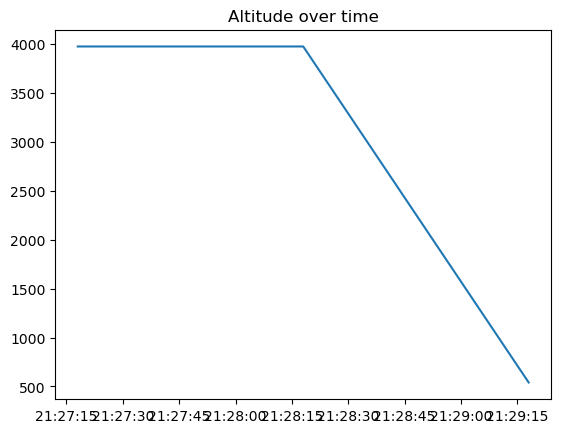

In [46]:
import matplotlib.pyplot as plt

aircraft = df[df["icao24"] == "a0b845"]

plt.plot(aircraft.index, aircraft["geo_altitude"])
plt.title("Altitude over time")
plt.show()


<Axes: >

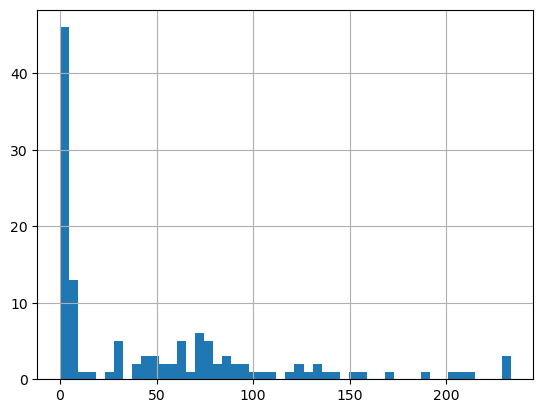

In [47]:
df["velocity"].hist(bins=50)


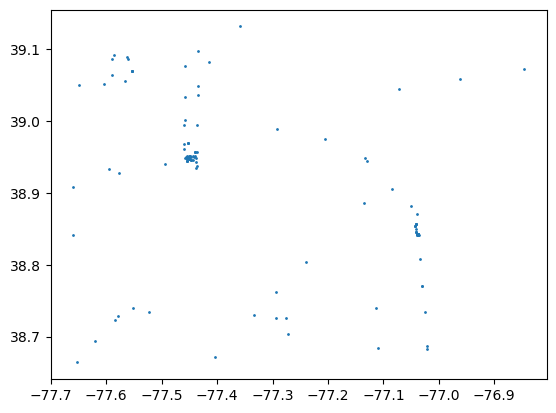

In [48]:
plt.scatter(df["longitude"], df["latitude"], s=1)


In [49]:
# Feature Engineering  
# Lag Feature 
df["velocity_lag1"] = df.groupby("icao24")["velocity"].shift(1)

df["velocity_rolling_mean"] = (
    df.groupby("icao24")["velocity"]
      .rolling(window=5)
      .mean()
      .reset_index(level=0, drop=True)
)

df["acceleration"] = (
    df.groupby("icao24")["velocity"].diff()
)

df["altitude_rate"] = (
    df.groupby("icao24")["geo_altitude"].diff()
)



In [50]:
flight_features = df.groupby("icao24").agg({

    "velocity": ["mean", "max", "std"],
    "geo_altitude": ["mean", "max"],
    "vertical_rate": ["mean", "std"],
    
})

print(flight_features)

          velocity                    geo_altitude           vertical_rate  \
              mean     max        std         mean       max          mean   
icao24                                                                       
a01097  158.410000  158.41        NaN      3970.02   3970.02      6.830000   
a0b845   37.590000   89.11  46.159308      2827.02   3970.02     10.080000   
a12322    0.000000    0.00   0.000000       541.02    541.02     16.580000   
a12aa5    2.076667    6.17   3.545058       541.02    541.02     16.580000   
a12ac9   91.695000  100.54  12.508719       567.69    571.50      0.165000   
a12e57    0.000000    0.00   0.000000       571.50    571.50      0.000000   
a1afde    2.830000    6.43   3.283428       571.50    571.50      0.000000   
a203a9  105.103333  128.64  25.364149       777.24   1455.42     14.630000   
a240dc   80.306667   88.74   8.800508       579.12    708.66     -2.816667   
a29aff    4.890000    4.89        NaN       419.10    419.10    

In [52]:
flight_features.columns = [
    "_".join(col) for col in flight_features.columns
]
flight_features = flight_features.dropna()
